In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime

# 황사 기후 불러오기

In [4]:
# 황사데이터 가져오기
df_h = pd.read_csv('./황사.csv', encoding='euckr')

# 시간 datetim형식으로 바꾸기
df_h['일시'] = pd.to_datetime(df_h['일시'], format='%Y-%m-%d')

# 2006 - 2021-08-31의 기후 데이터만 가져오기
df_h = df_h[df_h['일시'] > '2006-12-09']
df_h = df_h[df_h['일시'] < '2021-09-01']
df_h = df_h.reset_index()
df_h.drop('index', axis=1, inplace=True)

# 동부, 서부, 남부지역 군집
# 서
west_li = ['서울', '강화', '수원', '안면도(감)', '군산', '광주', '광덕산', '백령도', '관악산', '오성산', 
           '전주', '북격렬비도', '천안', '연평도']
# 동
east_li = ['춘천', '추풍령', '안동', '대구', '속초', '북춘천', '대관령', '춘천', '울릉도독도(감)', '영월', '울진', '문경', '영덕']
# 남
south_li = ['고산', '진도군', '구덕산', '울산', '흑산도', '진도(첨찰산)', '진주']

no_li=[]
for i in df_h['지점명']:
    if i in west_li:
        no_li.append('d1')
    elif i in east_li:
        no_li.append('d2')
    else:
        no_li.append('d3')
        

df_h['군집'] = no_li

# 필요없는 column drop
df_h.drop('지점', axis=1, inplace=True)
df_h.rename({'일 미세먼지 농도(㎍/㎥)' : '농도'}, axis=1, inplace=True)

df_h_test = df_h[df_h.columns]

# 군집별 날짜마다 평균으로 묶어주기
df_h_test = df_h_test.groupby(['군집', '일시']).agg({ '농도':'mean'})
df_h_test = df_h_test.reset_index()

# 미세먼지 농도마다 군집번호 column에 넣기
tdf_h = pd.DataFrame({'일시':df_h_test['일시'].unique()})

gun_li_h = list(df_h_test['군집'].unique())

for gun in gun_li_h:
    tmp_h = df_h_test[df_h_test['군집']==gun].drop('군집',axis=1)
    tmp_h.columns = ['일시', f'{gun}농도']
    tdf_h = pd.merge(tdf_h,tmp_h, how='left',on='일시')
df_h_n = tdf_h

import datetime as dt

# 2006-2021까지 비어있는 날들 보간으로 채워주기
dat_a = pd.DataFrame({'일시':np.arange(dt.datetime(2006,12,10),dt.datetime(2021,9, 1),dt.timedelta(days=1))})
dat_a['일시'] = dat_a['일시'].apply(lambda x : x.strftime('%Y-%m-%d'))

dat_a['일시'] = dat_a['일시'].astype('datetime64')

df_h_test = pd.merge(dat_a, df_h_n, how='left', on='일시')

df_h_test['d1농도'].interpolate(inplace=True)
df_h_test['d2농도'].interpolate(inplace=True)
df_h_test['d3농도'].interpolate(inplace=True)

df_h_test_a = df_h_test[df_h_test.columns]


In [6]:
df_h_test_a

,일시,d1농도,d2농도,d3농도
0,2006-12-10,24.555556,21.000000,23.000000
1,2006-12-11,38.111111,20.600000,17.333333
2,2006-12-12,63.444444,42.166667,26.666667
3,2006-12-13,95.777778,78.500000,43.333333
4,2006-12-14,64.666667,70.833333,60.000000
...,...,...,...,...
5374,2021-08-27,29.000000,32.200000,22.166667
5375,2021-08-28,30.272727,22.900000,16.250000
5376,2021-08-29,24.555556,23.200000,19.250000
5377,2021-08-30,35.363636,27.200000,19.400000


In [19]:
# 서부지역 추출
df_h_test_w = df_h_test[['일시','d1농도']]
df_h_test_w

,일시,d1농도
0,2006-12-10,24.555556
1,2006-12-11,38.111111
2,2006-12-12,63.444444
3,2006-12-13,95.777778
4,2006-12-14,64.666667
...,...,...
5374,2021-08-27,29.000000
5375,2021-08-28,30.272727
5376,2021-08-29,24.555556
5377,2021-08-30,35.363636


In [88]:
# 3일전 예측
dat = df_h_test_w[['일시']]
for i in range(7):
    dat[f't-{i}'] = df_h_test_w['d1농도'].shift(i)
e_day = 3
dat[f'est+{e_day}'] = df_h_test_w['d1농도'].shift(-1 * e_day)
dat

,일시,t-0,t-1,t-2,t-3,t-4,t-5,t-6,est+3
0,2006-12-10,24.555556,NaN,NaN,NaN,NaN,NaN,NaN,95.777778
1,2006-12-11,38.111111,24.555556,NaN,NaN,NaN,NaN,NaN,64.666667
2,2006-12-12,63.444444,38.111111,24.555556,NaN,NaN,NaN,NaN,95.555556
3,2006-12-13,95.777778,63.444444,38.111111,24.555556,NaN,NaN,NaN,68.250000
4,2006-12-14,64.666667,95.777778,63.444444,38.111111,24.555556,NaN,NaN,29.250000
...,...,...,...,...,...,...,...,...,...
5374,2021-08-27,29.000000,36.000000,18.363636,15.888889,21.555556,23.181818,16.750000,35.363636
5375,2021-08-28,30.272727,29.000000,36.000000,18.363636,15.888889,21.555556,23.181818,31.272727
5376,2021-08-29,24.555556,30.272727,29.000000,36.000000,18.363636,15.888889,21.555556,NaN
5377,2021-08-30,35.363636,24.555556,30.272727,29.000000,36.000000,18.363636,15.888889,NaN


# 우리나라 기후 불러오기

In [89]:
# 파일 불러오기
df = pd.read_csv('./국내기후(백령도제외).csv', index_col=0)

# 시간 datetim형식으로 바꾸기
df['시간'] = pd.to_datetime(df['시간'], format='%Y-%m-%d')

# 2006 - 2021-08-31의 기후 데이터만 가져오기
df_k = df[df['시간'] > '2006-12-09']
df_k = df_k[df_k['시간'] < '2021-09-01']
df_k = df_k.reset_index()
df_k.drop('index', axis=1, inplace=True)

# 황사예측에 필요없는 기후데이터 drop
df_seoul = df_k[df_k.columns]
df_seoul.columns
df_seoul.drop(['1시간 최다강수량','1시간 최다 일사량', '합계 일조 시간','합계 일사','일 최심신적설','일 최심적설',
               '합계 3시간 신적설',
             '합계 대형증발량','합계 소형증발량'], axis=1, inplace=True)

df_seoul.rename(columns={'시간':'일시', '관측지점':'도시명'}, inplace=True)


# 우리나라를 동부, 서부, 남부지역으로 군집
west_w = ['서울','전주','광주']
east_w = ['강릉','춘천','청주','대구']
south_w = ['제주']

no_li_w=[]
for i in df_seoul['도시명']:
    if i in west_w:
        no_li_w.append('ko_w')
    elif i in east_w:
        no_li_w.append('ko_e')
    else:
        no_li_w.append('ko_s')
        
df_seoul['군집'] = no_li_w

# 군집별로 같은 날짜로 묶어주기
df_seoul_n = df_seoul.groupby(['군집', '일시']).agg({'평균 기온':'mean','최저 기온':'min','최고 기온':'max',
                                                '일강수량':'mean','최대 순간풍속': 'mean','최대 순간 풍속 풍향':'mean',
                                               '최대 풍속':'mean','최대 풍속 풍향':'mean','평균 풍속':'mean','풍정합':'mean',
                                                '최대 풍향':'mean',
                                               '평균 이슬점온도':'mean','평균 상대습도':'mean','평균 증기압':'mean',
                                               '평균 현지기압':'mean','최고 해면 기압':'max','최저 해면기압':'min',
                                               '평균 해면기압':'mean',
                                               '평균 전운량':'mean','평균 중하층운량':'mean','평균 지면온도':'mean',
                                               '안개 계속 시간':'mean'})
df_seoul_n = df_seoul_n.reset_index()

# 각 column마다 군집별 이름 넣어주기
tdf_k = pd.DataFrame()

gun_k_li = list(df_seoul_n['군집'].unique())

for gun in gun_k_li:
    tmp_k = df_seoul_n[df_seoul_n['군집']==gun].drop(['군집','일시'],axis=1).reset_index(drop=True)
    tmp_k.columns = gun+tmp_k.columns
    tdf_k = pd.concat([tdf_k,tmp_k],axis=1)
df_k_g = tdf_k
df_k_g

,ko_e평균 기온,ko_e최저 기온,ko_e최고 기온,ko_e일강수량,ko_e최대 순간풍속,ko_e최대 순간 풍속 풍향,ko_e최대 풍속,ko_e최대 풍속 풍향,ko_e평균 풍속,ko_e풍정합,...,ko_w평균 상대습도,ko_w평균 증기압,ko_w평균 현지기압,ko_w최고 해면 기압,ko_w최저 해면기압,ko_w평균 해면기압,ko_w평균 전운량,ko_w평균 중하층운량,ko_w평균 지면온도,ko_w안개 계속 시간
0,1.550,-4.1,8.1,0.000,6.550,267.5,3.975,277.5,1.950,1684.50,...,59.200000,3.866667,1019.333333,1030.0,1025.9,1028.333333,2.366667,0.400000,2.333333,0.000000
1,1.675,-6.9,9.2,0.000,4.975,197.5,3.225,220.0,1.425,1231.00,...,58.566667,4.266667,1018.000000,1030.0,1024.1,1026.900000,4.666667,1.366667,2.866667,0.000000
2,4.675,-3.3,13.1,0.000,6.875,235.0,3.975,247.5,1.575,1360.75,...,65.466667,6.000000,1016.666667,1027.2,1023.0,1025.466667,3.266667,1.966667,4.233333,0.000000
3,5.725,-2.0,11.5,0.000,7.500,272.5,3.875,267.5,1.725,1490.25,...,75.233333,7.533333,1014.533333,1025.6,1020.8,1023.300000,6.933333,4.666667,6.000000,0.000000
4,4.050,-2.8,9.1,0.000,6.125,280.0,4.025,277.5,1.475,1274.25,...,66.333333,5.666667,1012.933333,1024.3,1019.4,1021.766667,5.700000,3.266667,3.900000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374,23.200,19.8,28.7,8.875,6.350,280.0,3.900,297.5,1.075,945.00,...,92.233333,25.266667,1004.433333,1014.4,1010.3,1012.766667,8.766667,5.566667,24.333333,0.166667
5375,24.575,19.3,31.9,0.075,5.525,192.5,3.350,192.5,1.450,1249.50,...,82.166667,24.300000,1005.633333,1015.5,1012.3,1013.866667,7.200000,4.833333,25.933333,0.000000
5376,23.675,18.6,30.6,6.600,5.725,225.0,3.475,220.0,1.400,1191.00,...,89.300000,26.600000,1005.133333,1015.5,1012.0,1013.366667,8.866667,5.433333,26.066667,0.000000
5377,24.200,19.2,30.6,0.050,4.500,165.0,2.750,217.5,1.250,1054.00,...,83.700000,25.700000,1007.200000,1016.8,1013.7,1015.433333,8.433333,5.000000,26.100000,0.000000


# 주변국 데이터 불러오기

In [86]:
# 주변국 기후데이터 가져오기
df_w = pd.read_csv('./preprocessed_주변국 기상데이터_199601to202108.csv', index_col=0)
# df_w.drop('index', axis=1, inplace=True)

# 2006년 이후 데이터만 가져오기
df_w['일시'] = pd.to_datetime(df_w['일시'], format='%Y-%m-%d')
df_w = df_w[df_w['일시'] > '2006-12-09']
df_w = df_w.reset_index()
df_w.drop('index', axis=1, inplace=True)

# 같은 날짜에 군집한 지역마다 기후 묶어주기
df_ww = df_w.groupby(['군집', '일시']).agg({ '습도':'mean','풍향':'mean', 
                                            '풍속':'mean', '강수량':'mean','해면기압':'mean', '이슬점 온도':'mean'})
df_ww = df_ww.reset_index()

# 군집한 지역의 기후마다 이름 붙여주기 
tdf = pd.DataFrame({'일시':df_ww['일시'].unique()})

gunli = list(df_ww['군집'].unique())

for gun in gunli:
    tmp = df_ww[df_ww['군집']==gun].drop('군집',axis=1)
    tmp.columns = ['일시', f'{gun}습도', f'{gun}풍향', f'{gun}풍속', f'{gun}강수량', f'{gun}해면기압', f'{gun}이슬점 온도']
    tdf = pd.merge(tdf,tmp, how='left',on='일시')
df_w_w = tdf
df_w_w

,일시,n1습도,n1풍향,n1풍속,n1강수량,n1해면기압,n1이슬점 온도,n2습도,n2풍향,n2풍속,...,n6풍속,n6강수량,n6해면기압,n6이슬점 온도,n7습도,n7풍향,n7풍속,n7강수량,n7해면기압,n7이슬점 온도
0,2006-12-10,56.928571,230.000000,1.160714,0.000000,1028.351488,-9.167857,69.571429,27.5,0.607143,...,2.017857,0.000000,1025.631786,-7.886429,64.904167,110.000000,2.041667,0.000000,1028.425000,-1.791667
1,2006-12-11,65.468750,202.500000,2.062500,0.445600,1026.965625,-4.284375,77.772321,80.0,0.281250,...,3.010714,0.000000,1021.521429,-3.608929,76.262500,263.333333,2.500000,-0.047822,1024.695833,1.304167
2,2006-12-12,72.770833,179.274917,1.005952,0.000000,1024.439583,-0.572024,73.654762,40.0,0.285714,...,2.364286,0.000000,1023.791071,-4.638214,79.154167,323.333333,1.791667,0.133333,1025.512500,3.220833
3,2006-12-13,62.916667,248.750000,1.416667,0.000000,1023.255208,-3.912500,55.000000,102.5,1.750000,...,2.282143,0.000000,1024.350714,-11.458214,71.641667,220.000000,1.666667,1.000000,1025.920833,1.837500
4,2006-12-14,60.915179,167.500000,0.805804,0.000000,1021.968527,-6.006473,66.916667,115.0,0.531250,...,2.389286,0.000000,1019.422857,-9.447500,68.450000,170.000000,1.875000,0.000000,1022.854167,-0.191667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374,2021-08-27,82.468750,111.250000,0.906250,0.880792,1011.759375,20.028125,80.593750,350.0,0.937500,...,2.800000,0.000000,1009.500000,16.523214,78.830556,240.000000,2.125000,-0.047822,1012.870833,21.366667
5375,2021-08-28,77.921875,115.000000,1.500000,0.000000,1013.007812,19.660938,75.125000,195.0,1.375000,...,1.996429,-0.594099,1011.968571,16.480000,81.301190,106.666667,1.404762,-0.739609,1012.662500,22.993452
5376,2021-08-29,83.125000,162.500000,1.031250,1.669771,1013.484375,19.915625,77.875000,42.5,1.218750,...,1.982143,-0.915458,1013.549643,17.045000,87.795833,210.000000,2.083333,-0.702848,1013.058333,23.450000
5377,2021-08-30,77.578125,183.750000,0.937500,0.000000,1015.429688,19.173437,73.281250,157.5,1.406250,...,1.510714,-0.915262,1015.932500,17.566429,83.704167,220.000000,1.916667,-0.625120,1012.554167,24.179167


In [101]:
# 우리나라+서부지역+주변국
dat_a = pd.merge(dat, df_w_w, how='left', on='일시')
dat_b = pd.concat([dat_a,df_k_g], axis=1)

In [102]:
dat_b

,일시,t-0,t-1,t-2,t-3,t-4,t-5,t-6,est+3,n1습도,...,ko_w평균 상대습도,ko_w평균 증기압,ko_w평균 현지기압,ko_w최고 해면 기압,ko_w최저 해면기압,ko_w평균 해면기압,ko_w평균 전운량,ko_w평균 중하층운량,ko_w평균 지면온도,ko_w안개 계속 시간
0,2006-12-10,24.555556,NaN,NaN,NaN,NaN,NaN,NaN,95.777778,56.928571,...,59.200000,3.866667,1019.333333,1030.0,1025.9,1028.333333,2.366667,0.400000,2.333333,0.000000
1,2006-12-11,38.111111,24.555556,NaN,NaN,NaN,NaN,NaN,64.666667,65.468750,...,58.566667,4.266667,1018.000000,1030.0,1024.1,1026.900000,4.666667,1.366667,2.866667,0.000000
2,2006-12-12,63.444444,38.111111,24.555556,NaN,NaN,NaN,NaN,95.555556,72.770833,...,65.466667,6.000000,1016.666667,1027.2,1023.0,1025.466667,3.266667,1.966667,4.233333,0.000000
3,2006-12-13,95.777778,63.444444,38.111111,24.555556,NaN,NaN,NaN,68.250000,62.916667,...,75.233333,7.533333,1014.533333,1025.6,1020.8,1023.300000,6.933333,4.666667,6.000000,0.000000
4,2006-12-14,64.666667,95.777778,63.444444,38.111111,24.555556,NaN,NaN,29.250000,60.915179,...,66.333333,5.666667,1012.933333,1024.3,1019.4,1021.766667,5.700000,3.266667,3.900000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374,2021-08-27,29.000000,36.000000,18.363636,15.888889,21.555556,23.181818,16.750000,35.363636,82.468750,...,92.233333,25.266667,1004.433333,1014.4,1010.3,1012.766667,8.766667,5.566667,24.333333,0.166667
5375,2021-08-28,30.272727,29.000000,36.000000,18.363636,15.888889,21.555556,23.181818,31.272727,77.921875,...,82.166667,24.300000,1005.633333,1015.5,1012.3,1013.866667,7.200000,4.833333,25.933333,0.000000
5376,2021-08-29,24.555556,30.272727,29.000000,36.000000,18.363636,15.888889,21.555556,NaN,83.125000,...,89.300000,26.600000,1005.133333,1015.5,1012.0,1013.366667,8.866667,5.433333,26.066667,0.000000
5377,2021-08-30,35.363636,24.555556,30.272727,29.000000,36.000000,18.363636,15.888889,NaN,77.578125,...,83.700000,25.700000,1007.200000,1016.8,1013.7,1015.433333,8.433333,5.000000,26.100000,0.000000


In [118]:
# 우리나라+주변국
dat_cc = pd.concat([df_w_w,df_k_g], axis=1)
dat_c = pd.merge(dat_cc, dat_c, how='left', on='일시')

In [116]:
dat_c = dat_a[['일시','est+3']]

In [117]:
dat_c

,일시,est+3
0,2006-12-10,95.777778
1,2006-12-11,64.666667
2,2006-12-12,95.555556
3,2006-12-13,68.250000
4,2006-12-14,29.250000
...,...,...
5374,2021-08-27,35.363636
5375,2021-08-28,31.272727
5376,2021-08-29,NaN
5377,2021-08-30,NaN


In [79]:
# 황사데이터 2019년 테스트데이터 분리
df_a = dat[dat['일시'] < '2019-01-01']
df_b = dat[dat['일시'] > '2019-12-31']
train = pd.concat([df_a,df_b])
test = dat[dat['일시'].astype('datetime64').dt.year == 2019]

In [103]:
# 우리나라+서부지역+주변국 2019년 테스트데이터 분리
df_a = dat_b[dat_b['일시'] < '2019-01-01']
df_b = dat_b[dat_b['일시'] > '2019-12-31']
train = pd.concat([df_a,df_b])
test = dat_b[dat_b['일시'].astype('datetime64').dt.year == 2019]

In [119]:
# 우리나라+주변국 2019년 테스트데이터 분리
df_a = dat_c[dat_b['일시'] < '2019-01-01']
df_b = dat_c[dat_b['일시'] > '2019-12-31']
train_c = pd.concat([df_a,df_b])
test_c = dat_c[dat_c['일시'].astype('datetime64').dt.year == 2019]

In [115]:
dat_c

,일시,n1습도,n1풍향,n1풍속,n1강수량,n1해면기압,n1이슬점 온도,n2습도,n2풍향,n2풍속,...,ko_w평균 상대습도,ko_w평균 증기압,ko_w평균 현지기압,ko_w최고 해면 기압,ko_w최저 해면기압,ko_w평균 해면기압,ko_w평균 전운량,ko_w평균 중하층운량,ko_w평균 지면온도,ko_w안개 계속 시간
0,2006-12-10,56.928571,230.000000,1.160714,0.000000,1028.351488,-9.167857,69.571429,27.5,0.607143,...,59.200000,3.866667,1019.333333,1030.0,1025.9,1028.333333,2.366667,0.400000,2.333333,0.000000
1,2006-12-11,65.468750,202.500000,2.062500,0.445600,1026.965625,-4.284375,77.772321,80.0,0.281250,...,58.566667,4.266667,1018.000000,1030.0,1024.1,1026.900000,4.666667,1.366667,2.866667,0.000000
2,2006-12-12,72.770833,179.274917,1.005952,0.000000,1024.439583,-0.572024,73.654762,40.0,0.285714,...,65.466667,6.000000,1016.666667,1027.2,1023.0,1025.466667,3.266667,1.966667,4.233333,0.000000
3,2006-12-13,62.916667,248.750000,1.416667,0.000000,1023.255208,-3.912500,55.000000,102.5,1.750000,...,75.233333,7.533333,1014.533333,1025.6,1020.8,1023.300000,6.933333,4.666667,6.000000,0.000000
4,2006-12-14,60.915179,167.500000,0.805804,0.000000,1021.968527,-6.006473,66.916667,115.0,0.531250,...,66.333333,5.666667,1012.933333,1024.3,1019.4,1021.766667,5.700000,3.266667,3.900000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374,2021-08-27,82.468750,111.250000,0.906250,0.880792,1011.759375,20.028125,80.593750,350.0,0.937500,...,92.233333,25.266667,1004.433333,1014.4,1010.3,1012.766667,8.766667,5.566667,24.333333,0.166667
5375,2021-08-28,77.921875,115.000000,1.500000,0.000000,1013.007812,19.660938,75.125000,195.0,1.375000,...,82.166667,24.300000,1005.633333,1015.5,1012.3,1013.866667,7.200000,4.833333,25.933333,0.000000
5376,2021-08-29,83.125000,162.500000,1.031250,1.669771,1013.484375,19.915625,77.875000,42.5,1.218750,...,89.300000,26.600000,1005.133333,1015.5,1012.0,1013.366667,8.866667,5.433333,26.066667,0.000000
5377,2021-08-30,77.578125,183.750000,0.937500,0.000000,1015.429688,19.173437,73.281250,157.5,1.406250,...,83.700000,25.700000,1007.200000,1016.8,1013.7,1015.433333,8.433333,5.000000,26.100000,0.000000


# machin learning

In [96]:
from sklearn.model_selection import train_test_split

In [120]:
x = train_c.dropna().drop(['일시','est+3'],axis=1)
y = train_c.dropna()['est+3']
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=111)

In [106]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train, y_train)
pred = svr.predict(x_val)
print('score : ', svr.score(x_val,y_val))

score :  -0.024001251908124077


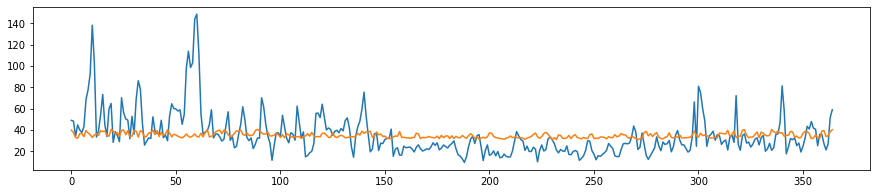

In [107]:
plt.figure(figsize=(15,3))
plt.plot(test['est+3'].reset_index(drop=True))
plt.plot(svr.predict(test.drop(['일시','est+3'],axis=1).reset_index(drop=True)))

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import AdaBoostRegressor

In [62]:
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import minmax_scale

In [63]:
lr = LinearRegression()
svr = SVR()
rfr = RandomForestRegressor()
xg = XGBRFRegressor()
ada = AdaBoostRegressor()

models = [lr, svr, rfr, xg, ada]

for m in models:
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    print('score : ', m.score(x_val,y_val))
    print('='*100)

score :  0.08687489502856383
score :  0.061603168423737475


KeyboardInterrupt: 

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns


score :  0.12102022436635818
mse : 743.1145120070045
score :  -0.024001251908124077
mse : 865.7197943578519
score :  0.15469217846681915
mse : 714.6472839395005
score :  0.15393325207296182
mse : 715.2889019066647
score :  -0.43670748217204225
mse : 1214.6333841884436


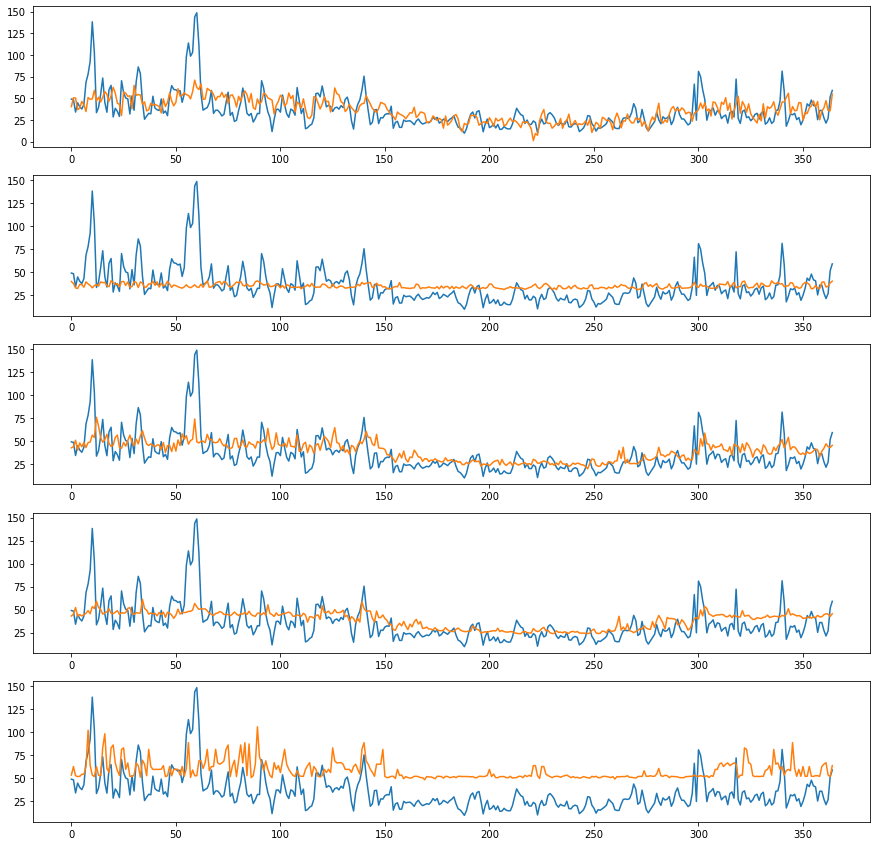

In [108]:
plt.figure(figsize=(15,15))
for i,m in enumerate(models):
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    print('score : ', m.score(x_val,y_val))
    print('mse :', mean_squared_error(y_val,pred))
    ax = plt.subplot(5,1,i+1)
    ax.plot(test[f'est+{e_day}'].reset_index(drop=True))
    ax.plot(m.predict(test.drop(['일시',f'est+{e_day}'],axis=1).reset_index(drop=True)))

In [ ]:
# 최적화 - ridge, lasso

In [109]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [110]:
rid = Ridge(alpha=0.05)
rid.fit(x_train, y_train)

print('train acc : ', rid.score(x_train, y_train))
print('test acc : ', rid.score(x_val, y_val))

train acc :  0.23486143635144774
test acc :  0.1210387869331977


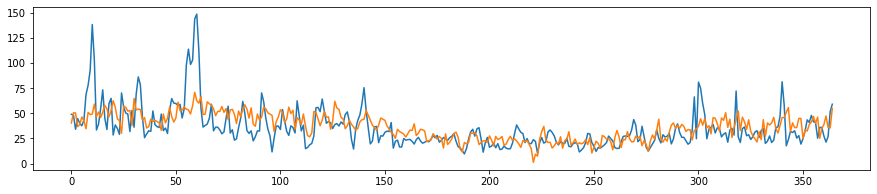

In [111]:
plt.figure(figsize=(15,3))
plt.plot(test['est+3'].reset_index(drop=True))
plt.plot(rid.predict(test.drop(['일시','est+3'],axis=1).reset_index(drop=True)))

In [ ]:
# 서부지역

score :  -0.013249049932848811


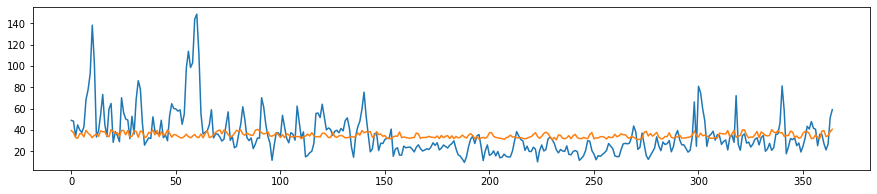

In [125]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train, y_train)
pred = svr.predict(x_val)
print('score : ', svr.score(x_val,y_val))

plt.figure(figsize=(15,3))
plt.plot(test_c['est+3'].reset_index(drop=True))
plt.plot(svr.predict(test_c.drop(['일시','est+3'],axis=1).reset_index(drop=True)))

score :  0.17833180355518874
mse : 489.99021764241155
score :  -0.013249049932848811
mse : 604.2367523177104
score :  0.07519418113949938
mse : 551.4948812928305
score :  0.11165456106688076
mse : 529.7522489587061
score :  -1.4352647477726865
mse : 1452.2357186769586


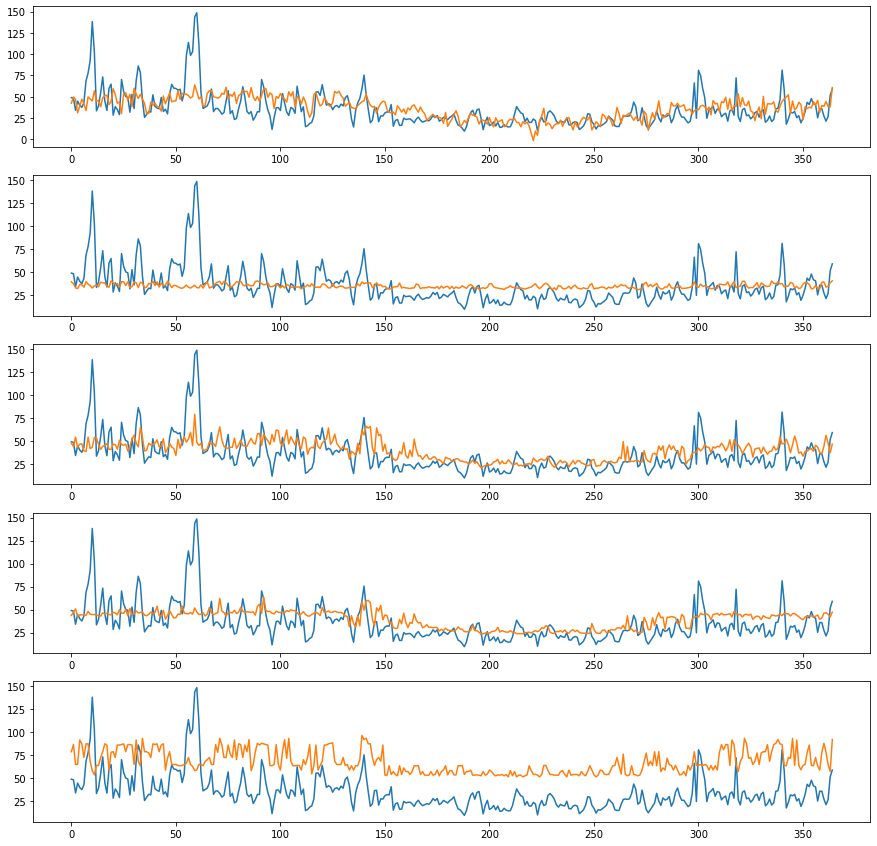

In [126]:
plt.figure(figsize=(15,15))
for i,m in enumerate(models):
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    print('score : ', m.score(x_val,y_val))
    print('mse :', mean_squared_error(y_val,pred))
    ax = plt.subplot(5,1,i+1)
    ax.plot(test_c[f'est+{e_day}'].reset_index(drop=True))
    ax.plot(m.predict(test_c.drop(['일시',f'est+{e_day}'],axis=1).reset_index(drop=True)))

train acc :  0.21143666360332136
test acc :  0.17853954869688615


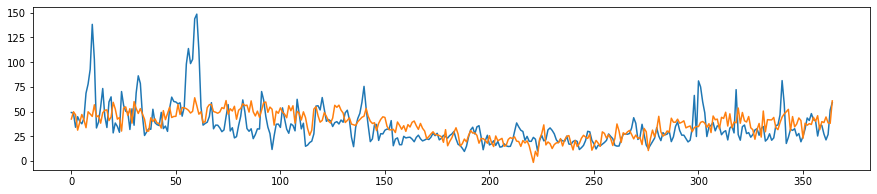

In [128]:
rid = Ridge(alpha=0.05)
rid.fit(x_train, y_train)

print('train acc : ', rid.score(x_train, y_train))
print('test acc : ', rid.score(x_val, y_val))

plt.figure(figsize=(15,3))
plt.plot(test_c['est+3'].reset_index(drop=True))
plt.plot(rid.predict(test_c.drop(['일시','est+3'],axis=1).reset_index(drop=True)))